# Module 4 GeoSpatial Data Analysis

In [1]:
import geopandas
df = geopandas.read_file('data/berlin-districts.geojson')

In [ ]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_price', legend=True, ax=ax)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_price', k=4, legend=True, ax=ax, 
        cmap='OrRd')

In [9]:
import mapclassify as mc
import libpysal as lp
import matplotlib.pyplot as plt
%matplotlib inline

y = df['median_price']


In [10]:
y.median()

42.0

In [11]:
yb = y > y.median()
sum(yb)

68

In [12]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

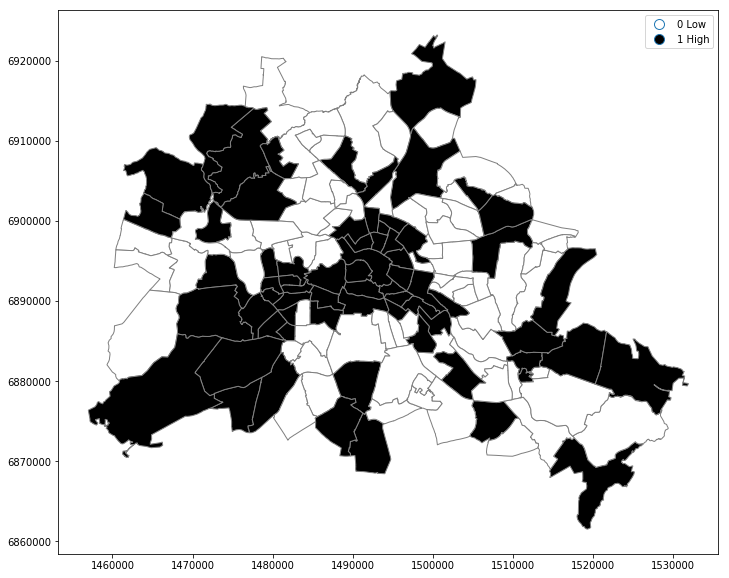

In [13]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

In [18]:
import pandas as pd
import shapely.geometry as shp
import geopandas

listings = pd.read_csv('./data/berlin-listings.csv.gz')
listings['geometry'] = listings[['longitude','latitude']].apply(shp.Point, axis=1)
listings = geopandas.GeoDataFrame(listings)
listings.crs = {'init':'epsg:4269'}
listings = listings.to_crs(epsg=3857)

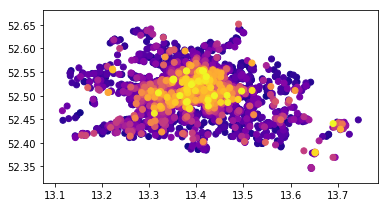

In [19]:
listings.sort_values('price').plot('price', cmap='plasma')

## Kernel Regression

In [20]:
model_data = listings[['accommodates', 'review_scores_rating', 
                       'bedrooms', 'bathrooms', 'beds', 
                       'price', 'geometry']].dropna()

In [23]:
import numpy as np
Xnames = ['accommodates', 'review_scores_rating', 
               'bedrooms', 'bathrooms', 'beds' ]
X = model_data[Xnames].values
X = X.astype(float)
y = np.log(model_data[['price']].values)

In [24]:
coordinates = np.vstack(model_data.geometry.apply(lambda p: np.hstack(p.xy)).values)

In [25]:
import sklearn.neighbors as skn
import sklearn.metrics as skm

In [26]:
shuffle = np.random.permutation(len(y))
train,test = shuffle[:14000],shuffle[14000:]

In [27]:
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
spatial = KNNR.fit(coordinates[train,:],
                  y[train,:])
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
attribute = KNNR.fit(X[train,:],
                    y[train,])
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
both = KNNR.fit(np.hstack((coordinates,X))[train,:],
                y[train,:])

In [28]:
sp_ypred =  spatial.predict(coordinates[test,:])
att_ypred = attribute.predict(X[test,:])
both_ypred = both.predict(np.hstack((X,coordinates))[test,:])

In [29]:
(skm.explained_variance_score(y[test,], sp_ypred),
 skm.explained_variance_score(y[test,], att_ypred),
 skm.explained_variance_score(y[test,], both_ypred))

(0.12239861413636022, 0.2887106167127167, 0.003992615263241683)

## Clustering

In [30]:
import sklearn.cluster as skc

In [31]:
coordinates = listings['geometry'].apply(lambda p: np.hstack(p.xy)).values
coordinates = np.vstack(coordinates)

In [32]:
clusterer = skc.DBSCAN(eps=1000).fit(coordinates)

In [33]:
clusterer.components_

array([[13.39609156, 52.58330601],
       [13.39858179, 52.57641673],
       [13.39926059, 52.58921822],
       ...,
       [13.32764443, 52.6024044 ],
       [13.3367755 , 52.6099338 ],
       [13.69440822, 52.36928602]])

In [34]:
nclusters = clusterer.p

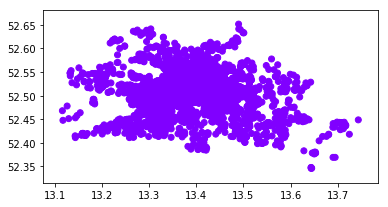

In [35]:
listings.assign(labels=clusterer.labels_).plot('labels', k=nclusters, cmap='rainbow')